# Surface heat flux movie

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.2dc9e53a278f4a668deed98ee28722ab/status,


In [81]:
client.close()
cluster.close()

In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
import json
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import gsw
from fastjmd95 import jmd95numba

In [4]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [5]:
ds_slt = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg_new.zarr'), consolidated=False)
ds_tmp = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/ds_tmp_wg.zarr'), consolidated=False)

In [6]:
ds_orig = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)
ds_ll = faces_dataset_to_latlon(ds_orig)
ds_ll_drop = ds_ll.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50)#(i=100, i_g=100)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50)#(i=100, i_g=100)

/tmp/ipykernel_357/4055097600.py:4: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50)#(i=100, i_g=100)
/tmp/ipykernel_357/4055097600.py:5: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50)#(i=100, i_g=100)


In [7]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row
j_g_upper = 81
i_g_right = 119
i_g_left = 22

In [8]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(lower_lat, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(left_lon, i_g_right))

In [9]:
#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

In [10]:
ds_wg = ds.isel(**lat_range, **lon_range)
coords_wg = coords.isel(**lat_range, **lon_range)

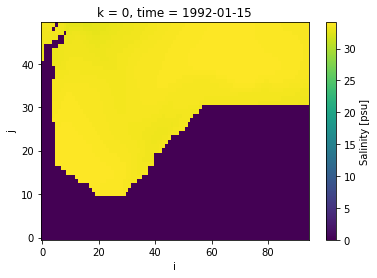

In [11]:
ds_wg.SALT[0,0].plot()

In [11]:
sigma2 = xr.apply_ufunc(jmd95numba.rho, ds_wg.SALT, ds_wg.THETA, 2000,
                            output_dtypes=[ds_wg.SALT.dtype],
                            dask='parallelized').reset_coords(drop=True)

In [12]:
sigma2

,Array,Chunk
Bytes,260.93 MiB,654.30 kiB
Shape,"(288, 50, 50, 95)","(1, 50, 50, 67)"
Count,72579 Tasks,576 Chunks
Type,float32,numpy.ndarray


In [13]:
mask = coords_wg.hFacC > 0

In [14]:
sigma2_m = sigma2.where(mask)

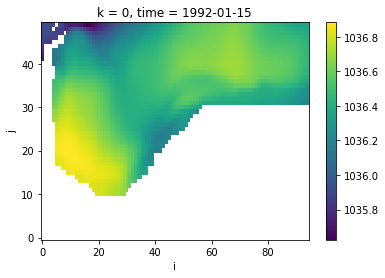

In [16]:
sigma2_m[0,0].plot()

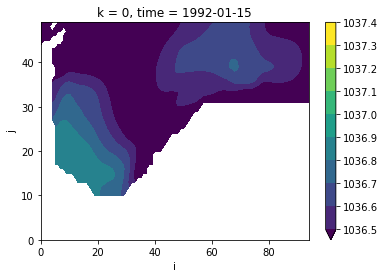

In [17]:
sigma2_m[0, 0].plot.contourf(levels=np.arange(1036.5, 1037.5, 0.1))

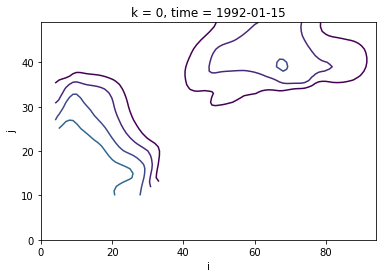

In [18]:
sigma2_m[0, 0].plot.contour(levels=np.arange(1036.5, 1037.5, 0.1))

In [19]:
#bottom water boundary
np.arange(1036.5, 1037.5, 0.025)[25]

1037.1250000000023

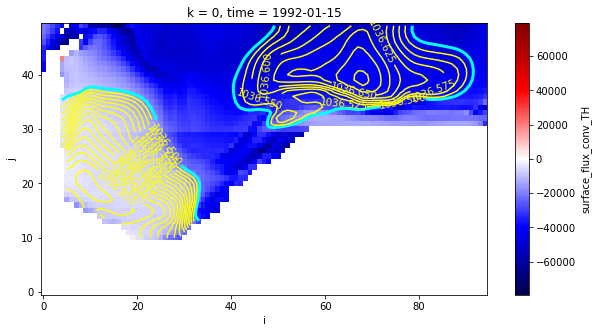

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
C = sigma2_m[0, 0].plot.contour(colors='yellow', levels=np.arange(1036.5, 1037.5, 0.025), ax=ax)
# makes first contour thicker and cyan, can do for contour line dividing bottom water (index 25 w current arange)
C.collections[0].set_color('cyan') 
C.collections[0].set_linewidth(3)
plt.clabel(C)
ds_tmp.surface_flux_conv_TH[0,0].where(mask[0]).plot(cmap='seismic')

## 3D surface heat flux

# Surface heat flux without making it 3D variable

In [18]:
import xarray as xr
from xmovie import Movie

In [19]:
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

In [20]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

ds_ll = faces_dataset_to_latlon(ds)

ds_before_drop = ds_ll.roll(i=50, i_g=50)

ds = ds_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

#WG boundaries (65˚W, 30˚E; 80˚S, 55˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745# 93 #-55.107994˚
j_g_lower = 31
j_g_upper = 81
i_g_right = 119
i_g_left = 24

#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(j_g_lower, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(i_g_left, i_g_right))

#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

/tmp/ipykernel_357/2556715282.py:5: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_before_drop = ds_ll.roll(i=50, i_g=50)


In [21]:
ds_wg = ds.isel(**lat_range, **lon_range)

In [22]:
coords = ds_wg.coords.to_dataset().reset_coords()
ds_wg = ds_wg.reset_coords(drop=True)

In [23]:
mask = coords.hFacC[0]>0

In [24]:
ds_wg.TFLUX

<xarray.DataArray 'TFLUX' (time: 288, j: 50, i: 95)>
dask.array<getitem, shape=(288, 50, 95), dtype=float32, chunksize=(1, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i
Attributes:
    long_name:      total heat flux (match heat-content variations), >0 incre...
    standard_name:  TFLUX
    units:          W/m^2

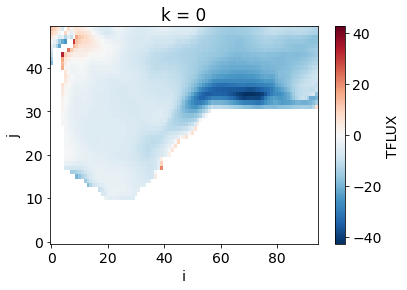

In [25]:
ds_wg.TFLUX.mean(dim='time').where(mask).plot()

In [29]:
heat_flux = ds_wg.TFLUX.where(mask)
heat_flux.load()

<xarray.DataArray 'TFLUX' (time: 288, j: 50, i: 95)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [ 90.79456   ,  77.96946   ,  65.490036  , ...,  87.208725  ,
          86.38823   ,  86.99164   ],
        [101.13143   ,  92.11824   ,  81.88107   , ...,  94.821     ,
          93.73528   ,  93.6231    ],
        [108.555756  , 101.12008   ,  91.92593   , ...,  95.79296   ,
          94.687004  ,  94.11241   ]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
...
        [ 53.826534  ,  37.37913   ,  18.9691    , ...,  -0.5526386 ,
          -0.2786405 ,   0.95476663],
        [ 85.25919   ,  67.18137   ,  48.048626  , ...,   3.7636745 ,
           4.816965  ,   6.6453485 ],
        [104.43991   ,  96.341545  ,  74.06023   , ...,   5.8029437 ,
           7.2984676 ,   9.4490795 ]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [157.01521   , 160.5386    , 160.87712   , ..., 116.2859    ,
         113.126     , 111.77244   ],
        [156.34496   , 159.1058    , 161.53285   , ..., 124.73876   ,
         124.55168   , 127.55686   ],
        [157.04591   , 158.32336   , 157.0557    , ..., 126.85184   ,
         127.492     , 130.24353   ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    k        int64 0
Dimensions without coordinates: j, i
Attributes:
    long_name:      total heat flux (match heat-content variations), >0 incre...
    standard_name:  TFLUX
    units:          W/m^2

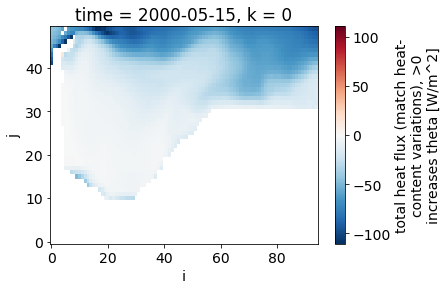

In [69]:
heat_flux[100].plot()

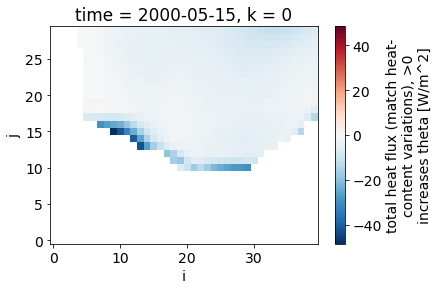

In [70]:
heat_flux.isel(i=slice(0,40), j=slice(0,30))[100].plot()

In [71]:
zoomed_in = heat_flux.isel(i=slice(0,40), j=slice(0,30))
zoomed_in.load()

<xarray.DataArray 'TFLUX' (time: 288, j: 30, i: 40)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  66.37561  ,
          62.691563 ,  58.669117 ],
        [        nan,         nan,         nan, ...,  73.2202   ,
          68.299194 ,  62.657864 ],
        [        nan,         nan,         nan, ...,  75.086685 ,
          73.484436 ,  71.27343  ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,  -5.8508143,
          -6.9847054,  -7.973308 ],
        [        nan,         nan,         nan, ...,  -4.7206535,
          -6.1067195,  -7.5104685],
        [        nan,         nan,         nan, ...,  -3.8811579,
          -5.3240314,  -6.86037  ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,   5.588437 ,
           4.869582 ,   4.750378 ],
        [        nan,         nan,         nan, ...,  12.682869 ,
           9.7272005,   7.5593596],
        [        nan,         nan,         nan, ...,  17.116564 ,
          16.155617 ,  13.913723 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    k        int64 0
Dimensions without coordinates: j, i
Attributes:
    long_name:      total heat flux (match heat-content variations), >0 incre...
    standard_name:  TFLUX
    units:          W/m^2

In [34]:
def contour_surf(da, fig, tt, *args, **kwargs):
    
    ax = fig.subplots()
    
    sigma2_m.isel(k=0, time=tt).plot.contour(colors='k', levels=[1037.125], linewidth=8, label='', ax=ax)
    #C.collections[0].set_color('cyan') #25 is index for bw boundary 1037.125
    C.collections[0].set_linewidth(3)
    #ax.clabel(C)
    
    surf = da.isel(time=tt).plot(cmap=plt.get_cmap('seismic'), vmin=-300, vmax=300, ax=ax)
    
    return ax, surf

(<AxesSubplot:title={'center':'time = 2000-05-15, k = 0'}, xlabel='i', ylabel='j'>,
 <matplotlib.collections.QuadMesh at 0x7f54123acdc0>)

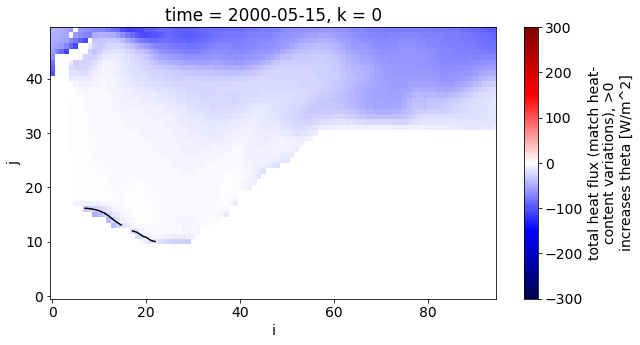

In [35]:
fig = plt.figure(figsize= (10, 5))

contour_surf(heat_flux, fig, 100)

In [36]:
tflux = Movie(heat_flux, contour_surf, 
                   input_check=False)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: The following kwargs were not used by contour: 'linewidth', 'label'
  primitive = ax.contour(x, y, z, **kwargs)


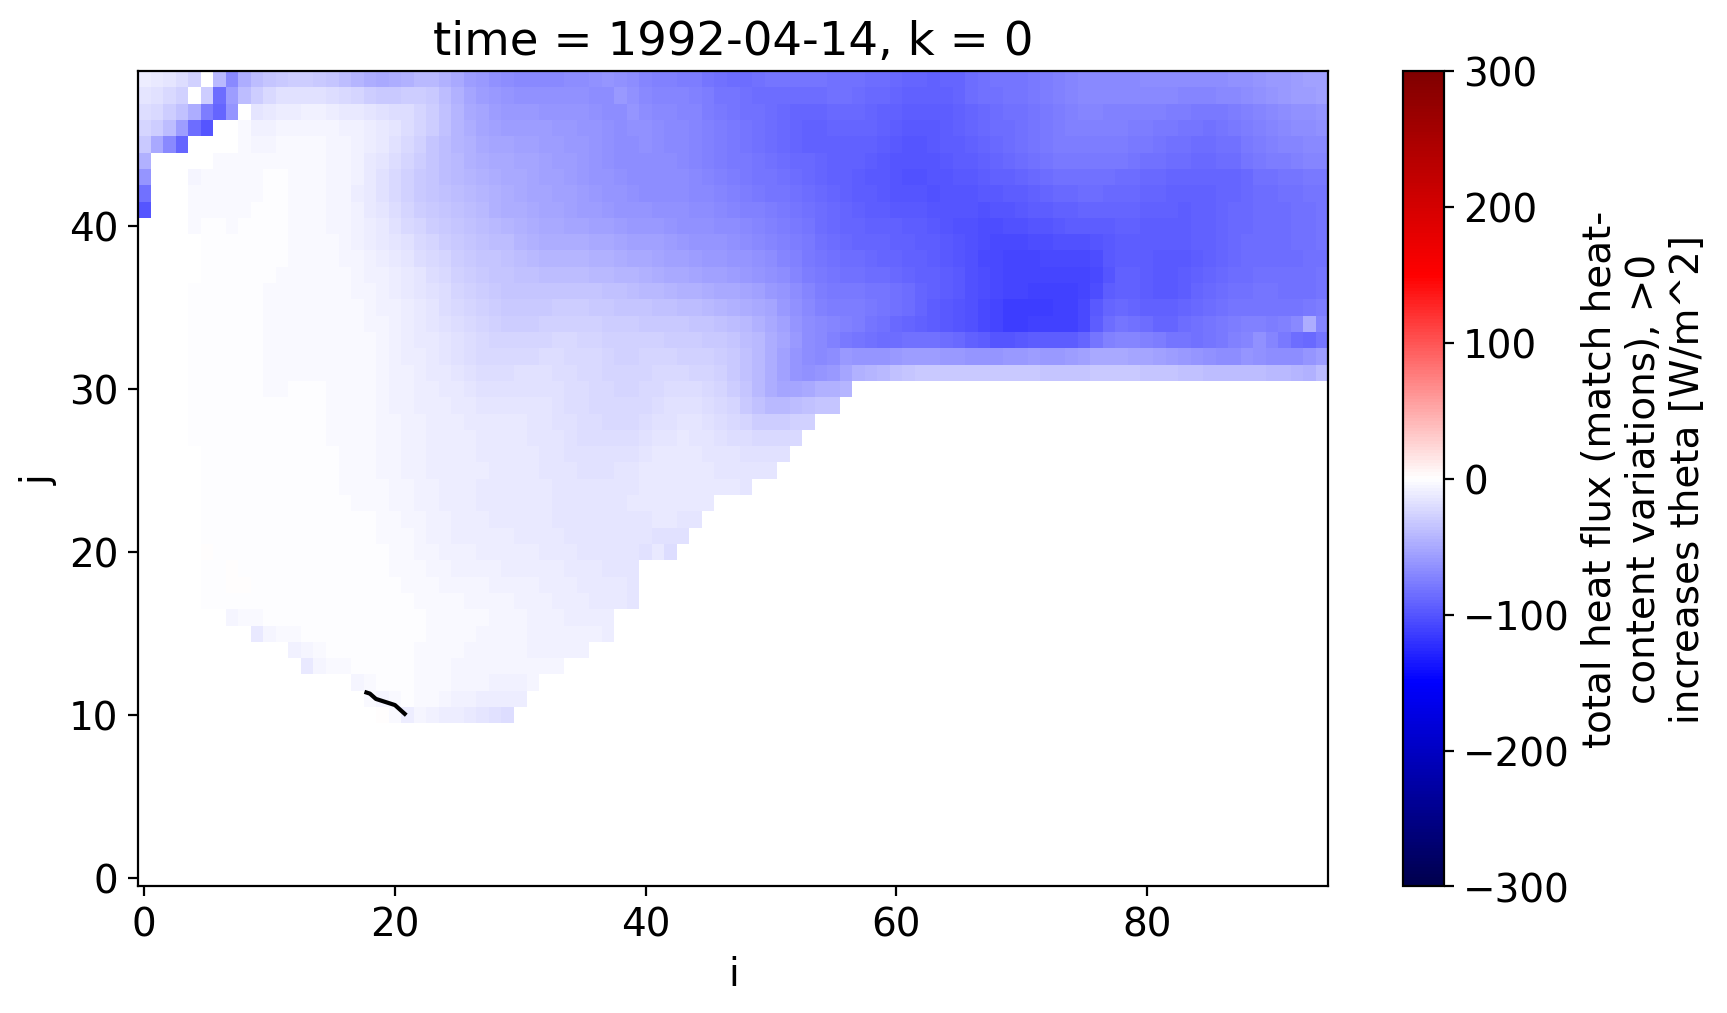

In [38]:
tflux.preview(3)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: The following kwargs were not used by contour: 'linewidth', 'label'
  primitive = ax.contour(x, y, z, **kwargs)


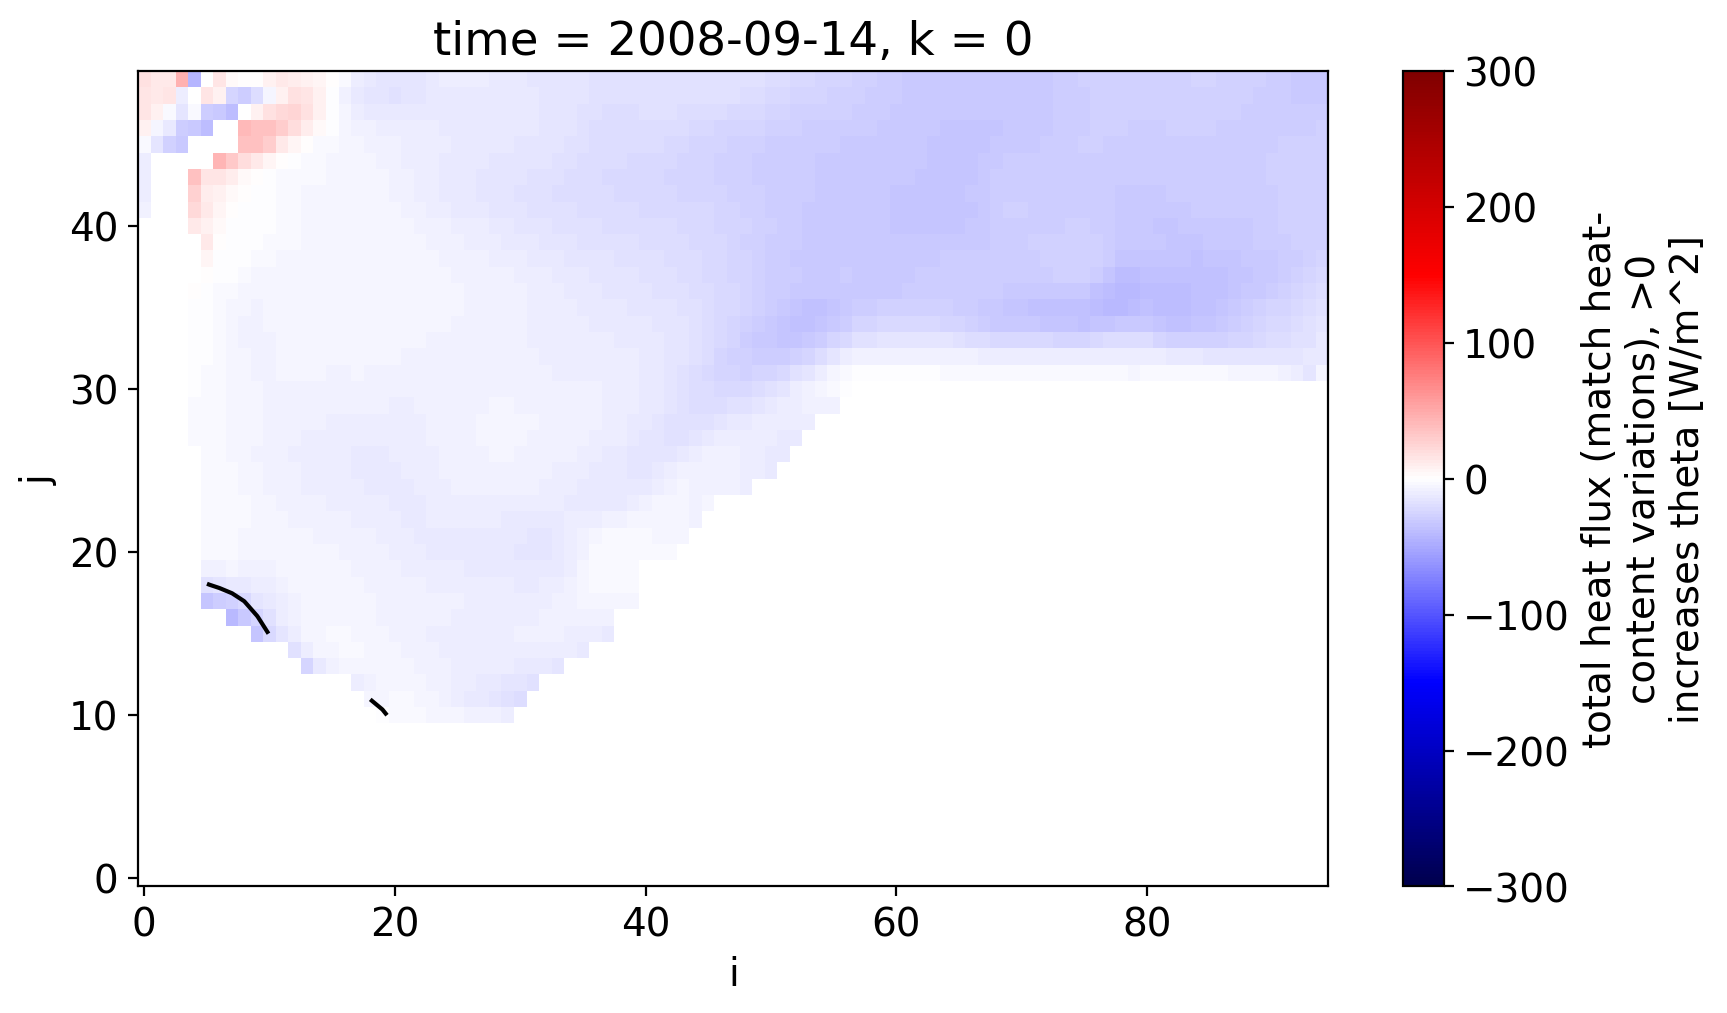

In [39]:
tflux.preview(200)

In [40]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.2dc9e53a278f4a668deed98ee28722ab/status,


In [42]:
#save surf heat flux over entire wg region
tflux.save('TFLUX.mp4', progress=True, overwrite_existing=True)

  0%|          | 0/288 [00:00<?, ?it/s]

Movie created at TFLUX.mp4


## ANOM from non3D